In [1]:

import pandas as pd #
import numpy as np
from joblib import load
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import seaborn as sns

crit_thresh = -0.097692
warn_thresh = -0.045423
#crit_thresh = np.percentile(df_val['anomaly_score'], 0.25)
#warn_thresh = np.percentile(df_val['anomaly_score'], 0.75)
#crit_thresh = -0.094870
#warn_thresh = -0.042534

# Load Isolation Forest model and scaler
scaler = load('./model/iso_scaler2.joblib')
iso_model = load('./model/iso_model2.joblib')

# Load datasets
#df_val = pd.read_csv("./data/validate.csv")
#df_val = pd.read_csv("./data/devAll2_prepared.csv")
#df1 = pd.read_csv("./data/dev101_prepared.csv")
#df2 = pd.read_csv("./data/dev102_prepared.csv")

#df_val = pd.concat([df1, df2], ignore_index=True)
df_val = pd.read_csv("./../../data/dataSet1_prepared.csv")
df_val = df_val.sort_values('timestamp').reset_index(drop=True)

In [2]:
df_val

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng,hour,day_of_week
0,2025-05-02 11:42:00.384119,102.0,22.200001,0.0,34.549099,61.175941,3.323395,8.637964,99.898933,11,4
1,2025-05-02 11:42:06.635276,101.0,28.799999,0.0,34.290073,62.429081,14.532875,8.637999,99.899010,11,4
2,2025-05-02 11:42:11.034615,102.0,22.200001,0.0,34.506374,61.542152,14.766250,8.637963,99.898933,11,4
3,2025-05-02 11:42:18.056572,101.0,28.799999,0.0,34.266041,64.082787,14.673310,8.637998,99.899010,11,4
4,2025-05-02 11:42:21.675224,102.0,22.200001,0.0,34.485012,61.767223,3.242806,8.637963,99.898933,11,4
...,...,...,...,...,...,...,...,...,...,...,...
375604,2025-07-22 19:39:28.596,101.0,25.600000,0.0,28.682386,74.146103,7.982772,8.638018,99.898956,19,1
375605,2025-07-22 19:39:35.152,102.0,23.299999,0.0,28.653008,73.873352,5.533101,8.637944,99.898926,19,1
375606,2025-07-22 19:39:41.789,101.0,25.600000,0.0,28.674376,74.270081,0.931764,8.638016,99.898956,19,1
375607,2025-07-22 19:39:48.552,102.0,23.299999,0.0,28.631645,73.905777,6.762322,8.637944,99.898926,19,1


In [3]:
#df_val  = pd.concat([df1, df2], ignore_index=True)
df_val.describe()

,devID,soil,rain,temp,humi,geo,lat,lng,hour,day_of_week
count,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000
mean,101.502898,43.992966,0.165806,29.900678,74.567455,8.239718,8.637978,99.901333,11.508755,3.100647
std,0.499992,13.708053,1.579886,3.189388,8.844493,6.654768,0.000038,1.461406,7.050659,1.968851
min,101.000000,20.200001,0.000000,24.238958,43.418247,0.000000,8.637330,99.166664,0.000000,0.000000
25%,101.000000,28.500000,0.000000,27.397957,68.698631,3.001680,8.637944,99.898926,5.000000,1.000000
50%,102.000000,46.799999,0.000000,28.586250,78.603645,4.549040,8.637974,99.898949,12.000000,3.000000
75%,102.000000,56.000000,0.000000,32.695885,80.863892,13.630129,8.638015,99.898972,18.000000,5.000000
max,102.000000,66.599998,41.630600,39.331657,88.510567,32.062466,8.638361,995.549988,23.000000,6.000000


## Threshold

In [4]:
#def rule_based_risk(row):
#   score = 0
#   
#   # Rainfall (mm/h)
#   if row['rain'] > 25:
#       score += 2
#   elif row['rain'] > 10:
#       score += 1
#
#   # Soil moisture (%)
#   if row['soil'] > 60:
#       score += 2
#   elif row['soil'] > 45:
#       score += 1
#
#   # Temperature (°C)
#   if row['temp'] < 27:
#       score += 2
#   elif row['temp'] < 32:
#       score += 1
#
#   # Humidity (%)
#   if row['humi'] > 80:
#       score += 2
#   elif row['humi'] > 65:
#       score += 1
#
#   # Geophone (Hz)
#   if row['geo'] > 25:
#       score += 1
#   elif row['geo'] > 10:
#       score += 0.5
#
#   if score >= 6:
#       return "Critical"
#   elif score >= 3:
#       return "Warning"
#   else:
#       return "Normal"
#
#feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
#X_val = df_val[feature_cols].values
#X_val_scaled = scaler.transform(X_val)
#
#df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)
#
#crit_thresh = np.percentile(df_val['anomaly_score'], 0.5)
#warn_thresh = np.percentile(df_val['anomaly_score'], 5)
#
#def model_based_risk(score):
#   if score < crit_thresh:
#       return "Critical"
#   elif score < warn_thresh:
#       return "Warning"
#   else:
#       return "Normal"
#
#df_val['model_risk'] = df_val['anomaly_score'].apply(model_based_risk)
#df_val['rule_risk'] = df_val.apply(rule_based_risk, axis=1)
#
#risk_levels = {'Normal': 0, 'Warning': 1, 'Critical': 2}
#
#def combine_weighted_risks(model_risk, rule_risk, w_model=0.6, w_rule=0.4):
#   score = w_model * risk_levels[model_risk] + w_rule * risk_levels[rule_risk]
#   
#   if score >= 1.5:
#       return "Critical"
#   elif score >= 0.5:
#       return "Warning"
#   else:
#       return "Normal"
#
#df_val['predicted_risk'] = df_val.apply(
#    lambda row: combine_weighted_risks(row['model_risk'], row['rule_risk']),
#    axis=1
#)
#
#print(df_val[['soil', 'rain', 'temp', 'humi', 'geo',
#              'anomaly_score', 'model_risk', 'rule_risk', 'predicted_risk']].head())

In [5]:
# สร้าง features
feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
X_val = df_val[feature_cols].values
X_val_scaled = scaler.transform(X_val)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)




def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val['predicted_risk'] = df_val['anomaly_score'].apply(classify_risk)

print("crit_thresh:", np.percentile(df_val['anomaly_score'], 0.4))
print("warn_thresh:", np.percentile(df_val['anomaly_score'], 1))

crit_thresh: -0.08855809389008698
warn_thresh: -0.04339355209459609


In [6]:
critical_group = df_val[df_val['anomaly_score'] < crit_thresh]
print("critical_group")
print(critical_group[feature_cols].describe())

critical_group
              soil         rain         temp         humi          geo
count  1156.000000  1156.000000  1156.000000  1156.000000  1156.000000
mean     57.794031    18.713999    26.816780    81.377728    21.601726
std       6.773179     8.990395     1.029185     2.514837     8.483113
min      20.900000     0.000000    24.949266    49.796524     0.656139
25%      53.700001    12.852400    26.235693    80.543449    17.497870
50%      56.900002    17.043400    26.652935    81.076561    19.388928
75%      63.799999    25.425400    27.366581    81.613010    31.985320
max      66.599998    41.630600    37.961777    88.413284    32.061317


In [7]:
warn_group = df_val[(df_val['anomaly_score'] < warn_thresh) & (df_val['anomaly_score'] >= crit_thresh) ]
print("warn_group")
print(warn_group[feature_cols].describe())

warn_group
              soil         rain         temp         humi          geo
count  2404.000000  2404.000000  2404.000000  2404.000000  2404.000000
mean     51.167346     8.174426    29.993307    73.691418    19.395090
std      14.096572     9.150814     4.583848    12.180900    10.060817
min      20.200001     0.000000    24.364462    44.434883     0.639543
25%      49.249999     0.000000    26.644924    62.779564    13.513120
50%      55.400002     6.146800    27.392616    80.636909    18.367271
75%      61.400002    12.014200    35.750744    81.486649    31.983600
max      66.599998    34.366199    39.222168    88.392303    32.062378


In [8]:
normal_group = df_val[df_val['anomaly_score'] >= warn_thresh]
print("normal_group")
print(normal_group[feature_cols].describe())

normal_group
                soil           rain           temp           humi  \
count  372049.000000  372049.000000  372049.000000  372049.000000   
mean       43.903728       0.056427      29.909661      74.551955   
std        13.687605       0.482491       3.178182       8.823055   
min        20.200001       0.000000      24.238958      43.418247   
25%        28.200001       0.000000      27.405968      68.677650   
50%        46.700001       0.000000      28.604942      78.557869   
75%        56.000000       0.000000      32.701225      80.839096   
max        66.400002      18.160999      39.331657      88.510567   

                 geo  
count  372049.000000  
mean        8.126120  
std         6.516194  
min         0.000000  
25%         2.992759  
50%         4.486095  
75%        13.454230  
max        32.062466  


C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\2053204387.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')


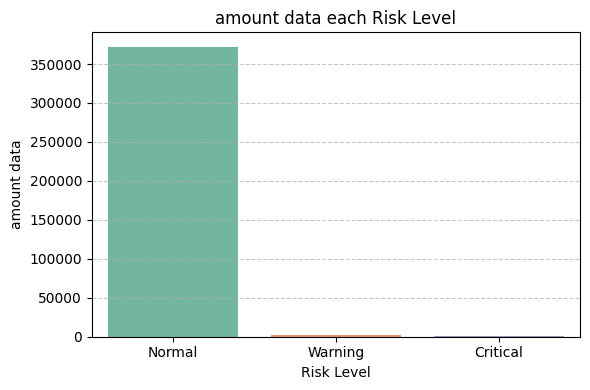

In [9]:

plt.figure(figsize=(6, 4))
sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribution of Anomaly Scores

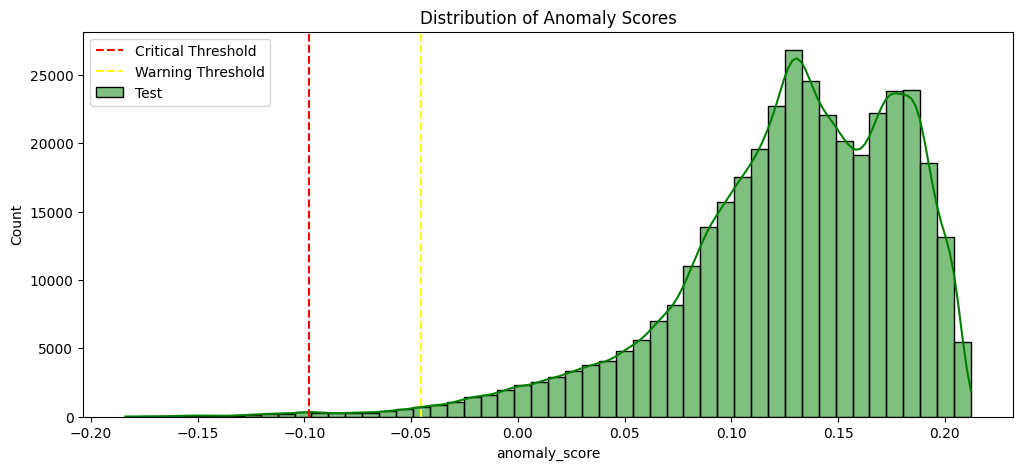

In [10]:
plt.figure(figsize=(12,5))
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()



## Z-score Outlier

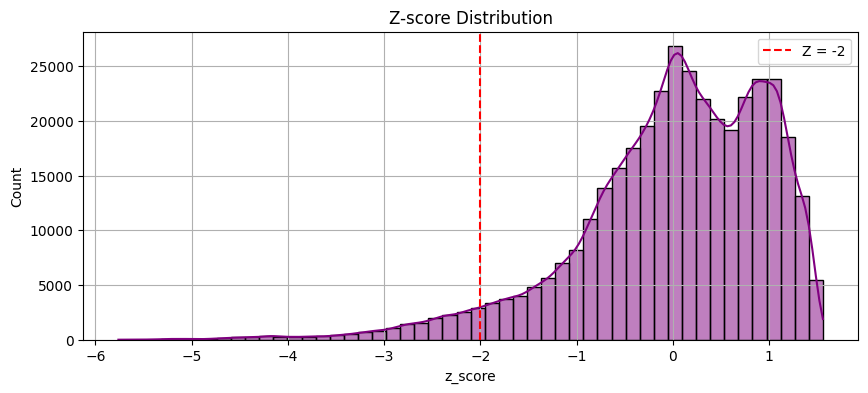

In [11]:
# ==== Z-score Outlier ====

mean_score = df_val['anomaly_score'].mean()
std_score = df_val['anomaly_score'].std()
df_val['z_score'] = (df_val['anomaly_score'] - mean_score) / std_score
df_val['z_outlier'] = df_val['z_score'].apply(lambda z: 'Anomaly' if z < -2 else 'Normal')

plt.figure(figsize=(10,4))
sns.histplot(df_val['z_score'], kde=True, bins=50, color='purple')
plt.axvline(-2, color='red', linestyle='--', label='Z = -2')
plt.title("Z-score Distribution")
plt.legend()
plt.grid(True)
plt.show()

## Mahalanobis Distance

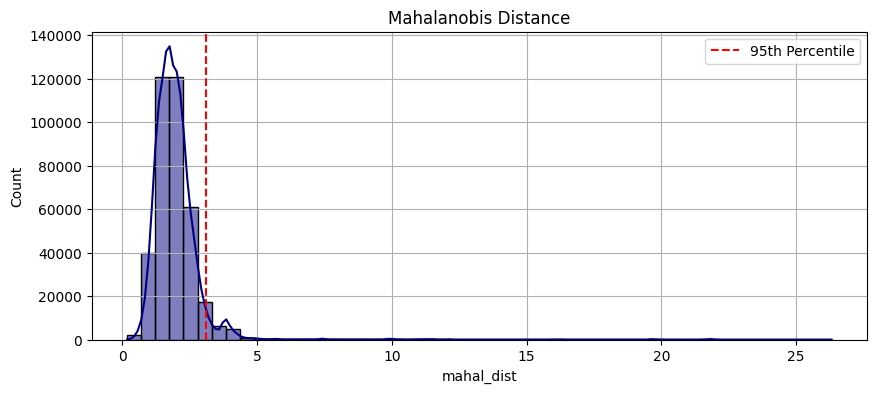

In [12]:
mean_vec = np.mean(X_val_scaled, axis=0)
cov_matrix = np.cov(X_val_scaled, rowvar=False)
inv_covmat = np.linalg.inv(cov_matrix)

df_val['mahal_dist'] = [mahalanobis(x, mean_vec, inv_covmat) for x in X_val_scaled]
mahal_thresh = np.percentile(df_val['mahal_dist'], 95)
df_val['mahal_outlier'] = df_val['mahal_dist'].apply(lambda d: 'Anomaly' if d > mahal_thresh else 'Normal')

plt.figure(figsize=(10,4))
sns.histplot(df_val['mahal_dist'], bins=50, kde=True, color='navy')
plt.axvline(mahal_thresh, color='red', linestyle='--', label='95th Percentile')
plt.title("Mahalanobis Distance")
plt.legend()
plt.grid(True)
plt.show()

## Percentile Threshold 5%

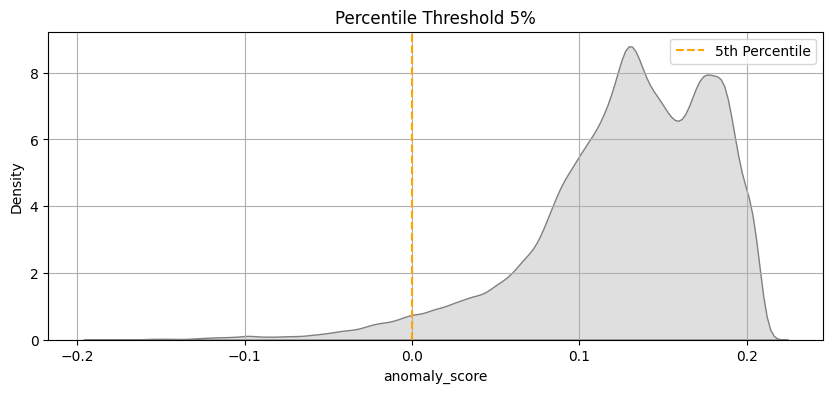

In [13]:
percentile = np.percentile(df_val['anomaly_score'], 3)
df_val['percentile_outlier'] = df_val['anomaly_score'].apply(lambda s: 'Anomaly' if s < percentile else 'Normal')

plt.figure(figsize=(10,4))
sns.kdeplot(df_val['anomaly_score'], fill=True, color='gray')
plt.axvline(percentile, color='orange', linestyle='--', label='5th Percentile')
plt.title("Percentile Threshold 5%")
plt.legend()
plt.grid(True)
plt.show()

## PCA

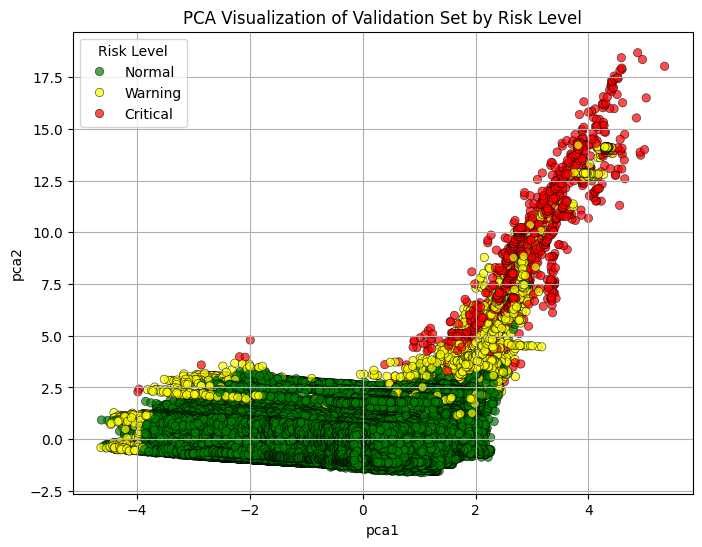

In [14]:
# Fit PCA
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_scaled)

# เพิ่มค่า PCA กลับเข้า df_val
df_val['pca1'] = X_val_pca[:, 0]
df_val['pca2'] = X_val_pca[:, 1]

# Map สีแบบกำหนดเอง
custom_palette = {
    'Normal': 'green',
    'Warning': 'yellow',
    'Critical': 'red'
}

# วาดกราฟ
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_val,
    x='pca1', y='pca2',
    hue='predicted_risk',
    palette=custom_palette,
    alpha=0.7,
    edgecolor='black'
)
plt.title('PCA Visualization of Validation Set by Risk Level')
plt.grid(True)
plt.legend(title='Risk Level')
plt.show()

In [15]:
explained_var = pca.explained_variance_ratio_
print(f"PCA explain {explained_var[0]*100:.2f}% and {explained_var[1]*100:.2f}% of data")


PCA explain 39.86% and 21.88% of data


In [16]:
# ดูว่าแต่ละ feature มีน้ำหนักกับแต่ละ principal component เท่าไหร่ x=PC1 y=PC2
pca_df = pd.DataFrame(pca.components_, columns=feature_cols, index=["PC1", "PC2"])
print(pca_df.T.sort_values("PC1", ascending=False))  # เรียงตามผลต่อแกน X


           PC1       PC2
humi  0.683381 -0.112352
soil  0.233576  0.329641
rain  0.132347  0.667754
geo  -0.010261  0.646716
temp -0.678831  0.120731


## Summary Statistics

In [17]:
print("\n== Z-score Outlier ==")
print(df_val['z_outlier'].value_counts())


== Z-score Outlier ==
z_outlier
Normal     358038
Anomaly     17571
Name: count, dtype: int64


In [18]:
print("\n== Percentile Outlier ==")
print(f"5th Percentile Threshold: {percentile:.4f}")
print(df_val['percentile_outlier'].value_counts())


== Percentile Outlier ==
5th Percentile Threshold: -0.0002
percentile_outlier
Normal     364340
Anomaly     11269
Name: count, dtype: int64


In [19]:
print("\n== Mahalanobis Outlier ==")
print(f"95th Percentile of Mahalanobis Distance: {mahal_thresh:.2f}")
print(df_val['mahal_outlier'].value_counts())


== Mahalanobis Outlier ==
95th Percentile of Mahalanobis Distance: 3.09
mahal_outlier
Normal     356828
Anomaly     18781
Name: count, dtype: int64


In [20]:
overlap = df_val[
    (df_val['z_outlier'] == 'Anomaly') &
    (df_val['percentile_outlier'] == 'Anomaly') &
    (df_val['mahal_outlier'] == 'Anomaly')
]
print(f"Anomalies detected by ALL 3 methods: {len(overlap)}")


Anomalies detected by ALL 3 methods: 9021


In [21]:
df_val['combined_outlier'] = df_val.apply(
    lambda row: (
        row['z_outlier'] == 'Anomaly' or
        row['percentile_outlier'] == 'Anomaly' or
        row['mahal_outlier'] == 'Anomaly'
    ),
    axis=1
)

print("\n== Combined Outlier ==")
print(df_val['combined_outlier'].value_counts())


== Combined Outlier ==
combined_outlier
False    351250
True      24359
Name: count, dtype: int64


In [22]:
print("\n== Mean Feature Values by Risk Level ==")
print(df_val.groupby('predicted_risk')[feature_cols].mean())


== Mean Feature Values by Risk Level ==
                     soil       rain       temp       humi        geo
predicted_risk                                                       
Critical        57.794031  18.713999  26.816780  81.377728  21.601726
Normal          43.903728   0.056427  29.909661  74.551955   8.126120
Warning         51.167346   8.174426  29.993307  73.691418  19.395090


In [23]:
print("\n== Risk Level ==")
print(df_val['predicted_risk'].value_counts())


== Risk Level ==
predicted_risk
Normal      372049
Warning       2404
Critical      1156
Name: count, dtype: int64


In [24]:
def risk_from_combined(row):
    if row['combined_outlier']:
        if row['anomaly_score'] < crit_thresh:
            return 'Critical'
        elif row['anomaly_score'] < warn_thresh:
            return 'Warning'
        else:
            return 'Warning'  
    return 'Normal'

df_val['risk_level_final'] = df_val.apply(risk_from_combined, axis=1)
print("\n== risk level final ==")
print(df_val['risk_level_final'].value_counts())


== risk level final ==
risk_level_final
Normal      351250
Warning      23203
Critical      1156
Name: count, dtype: int64


In [25]:
print("\n== Risk final Proportion ==")
print("Validation:", df_val['risk_level_final'].value_counts(normalize=True))


== Risk final Proportion ==
Validation: risk_level_final
Normal      0.935148
Warning     0.061774
Critical    0.003078
Name: proportion, dtype: float64


In [26]:
print("\n== Risk Proportion ==")
print("Validation:", df_val['predicted_risk'].value_counts(normalize=True))


== Risk Proportion ==
Validation: predicted_risk
Normal      0.990522
Warning     0.006400
Critical    0.003078
Name: proportion, dtype: float64


##  Signal-to-Noise Ratio (SNR)

In [27]:
def compute_snr(signal):
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    return mean_signal / std_signal if std_signal != 0 else 0

for col in feature_cols:
    snr = compute_snr(df_val[col])
    print(f"SNR of {col}: {snr:.2f}")


SNR of soil: 3.21
SNR of rain: 0.10
SNR of temp: 9.38
SNR of humi: 8.43
SNR of geo: 1.24


In [28]:
for col in feature_cols:
    normal_snr = compute_snr(df_val[df_val['predicted_risk'] == 'Normal'][col])
    anomaly_snr = compute_snr(df_val[df_val['predicted_risk'] != 'Normal'][col])
    print(f"{col}: Normal SNR={normal_snr:.2f}, Anomaly SNR={anomaly_snr:.2f}")


soil: Normal SNR=3.21, Anomaly SNR=4.23
rain: Normal SNR=0.12, Anomaly SNR=1.12
temp: Normal SNR=9.41, Anomaly SNR=7.08
humi: Normal SNR=8.45, Anomaly SNR=7.10
geo: Normal SNR=1.25, Anomaly SNR=2.09


## Mean Absolute Error (MAE)

In [29]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
interval = df_val['timestamp'].diff().median()
print(f"Sampling interval: {interval}")


Sampling interval: 0 days 00:00:07.404769500


In [30]:
window_size = int(pd.Timedelta('1H') / interval)
print(f"Rolling window size for 1 hour: {window_size}")


Rolling window size for 1 hour: 486


C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\504831528.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window_size = int(pd.Timedelta('1H') / interval)


In [31]:
interval = df_val['timestamp'].diff().median()
window_size = int(pd.Timedelta('1H') / interval)

print(f"Using rolling window size = {window_size} for 1 hour")

for col in feature_cols:
    df_val[f'{col}_roll_mean'] = df_val[col].rolling(window=window_size, center=True).mean()
    df_val[f'{col}_mae'] = (df_val[col] - df_val[f'{col}_roll_mean']).abs()

    mae = df_val[f'{col}_mae'].mean()
    print(f"MAE for {col} (vs rolling mean): {mae:.2f}")


Using rolling window size = 486 for 1 hour
MAE for soil (vs rolling mean): 1.82
MAE for rain (vs rolling mean): 0.11
MAE for temp (vs rolling mean): 0.41
MAE for humi (vs rolling mean): 1.72
MAE for geo (vs rolling mean): 5.23


C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\2248412977.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window_size = int(pd.Timedelta('1H') / interval)


## Cross-Correlation

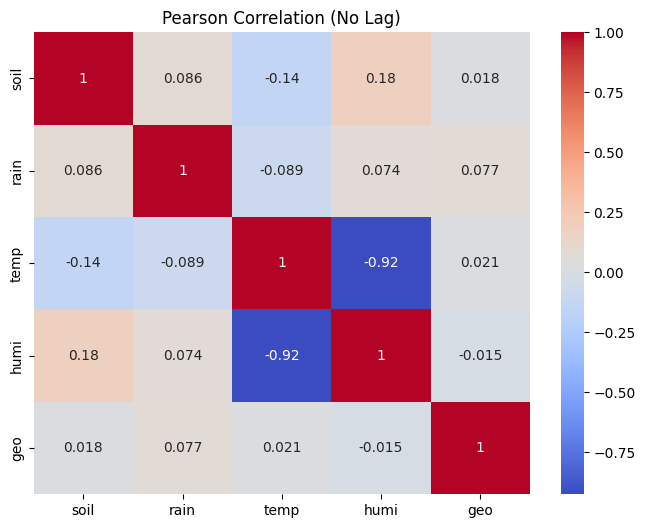

In [32]:
corr_matrix = df_val[feature_cols]
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm')
plt.title("Pearson Correlation (No Lag)")
plt.show()

In [33]:
def lag_corr(x, y, max_lag=window_size*10):
    lags = []
    corrs = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            corr = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(x[lag:], y[:-lag])[0, 1]
        else:
            corr = np.corrcoef(x, y)[0, 1]
        lags.append(lag)
        corrs.append(corr)
    return lags, corrs


C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\1202832202.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = df_val['rain'].fillna(method='ffill').values
C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\1202832202.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_val['soil'].fillna(method='ffill').values


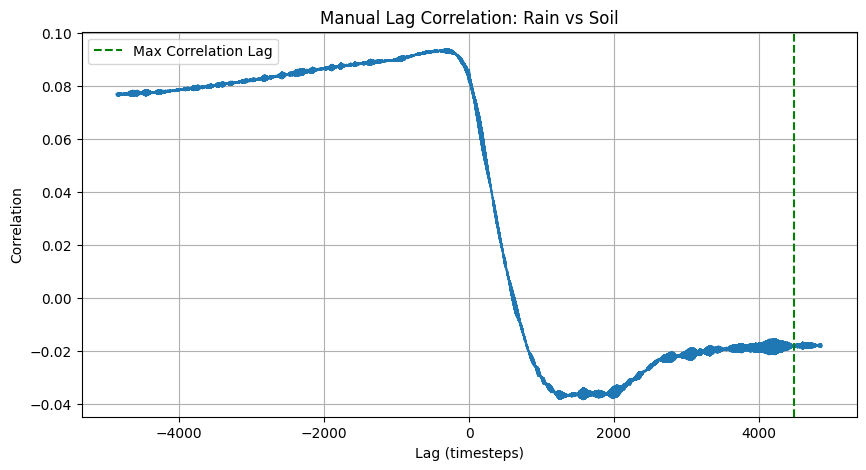

In [34]:
x = df_val['rain'].fillna(method='ffill').values
y = df_val['soil'].fillna(method='ffill').values
lags, corrs = lag_corr(x, y, max_lag=window_size*10)

plt.figure(figsize=(10, 5))
plt.plot(lags, corrs)
plt.axvline(x=np.argmax(corrs) - 60, color='green', linestyle='--', label='Max Correlation Lag')
plt.title("Manual Lag Correlation: Rain vs Soil")
plt.xlabel("Lag (timesteps)")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend()
plt.show()


C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\3179048846.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = df_val['rain'].fillna(method='ffill').values
C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\3179048846.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_val['soil'].fillna(method='ffill').values


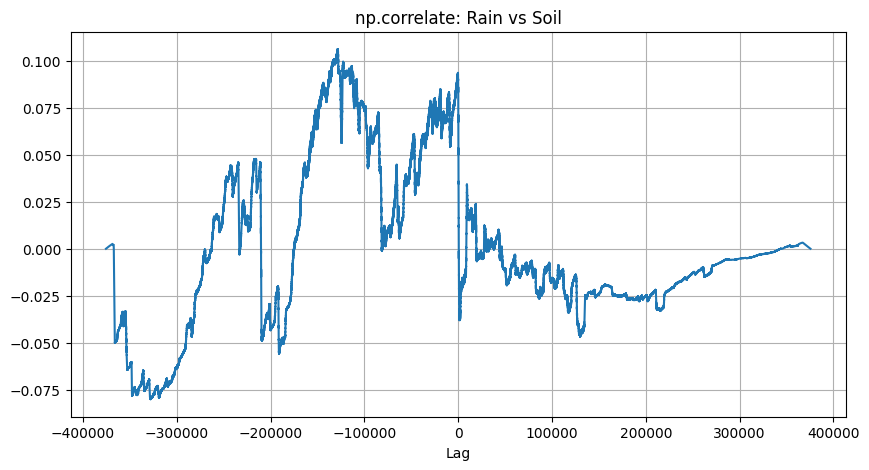

In [35]:
x = df_val['rain'].fillna(method='ffill').values
y = df_val['soil'].fillna(method='ffill').values

x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

corr = np.correlate(x, y, mode='full') / len(x)
lags = np.arange(-len(x)+1, len(x))

plt.figure(figsize=(10,5))
plt.plot(lags, corr)
plt.title("np.correlate: Rain vs Soil")
plt.xlabel("Lag")
plt.grid(True)
plt.show()


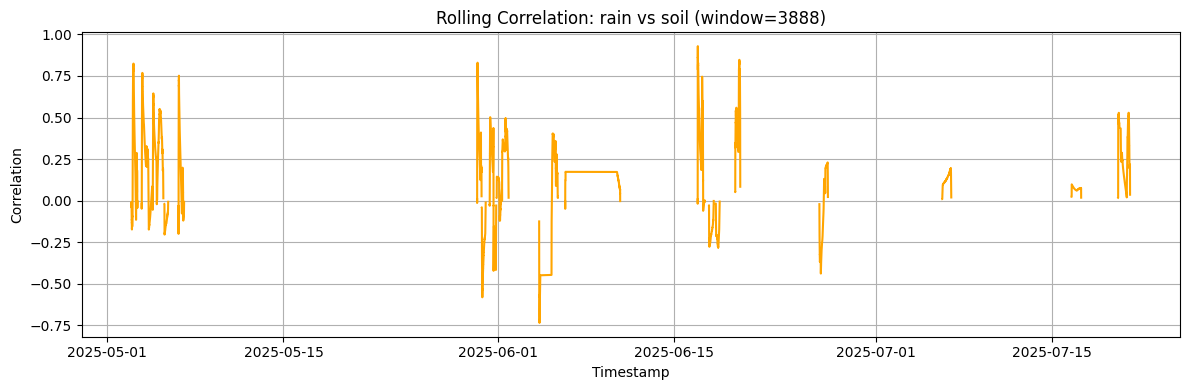

In [36]:
# ตัวอย่าง: ถ้า sampling ทุก 10 นาที → 48 จุด = 8 ชั่วโมง
df = df_val.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

rolling_corr = df['rain'].rolling(window_size*8).corr(df['soil'])

plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], rolling_corr, color='orange')
plt.title(f"Rolling Correlation: rain vs soil (window={window_size*8})")
plt.xlabel("Timestamp")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

## histogram

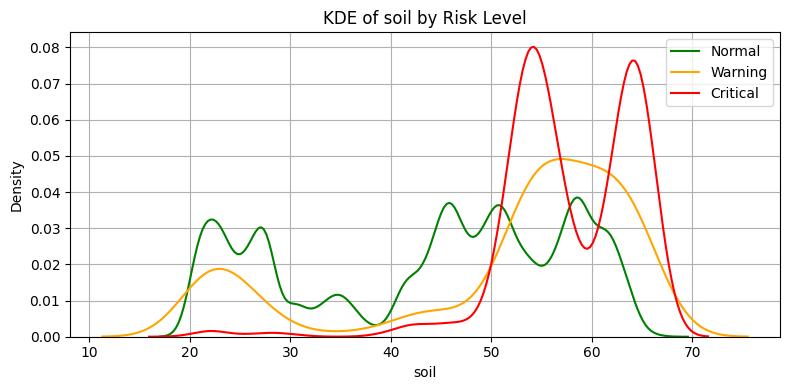

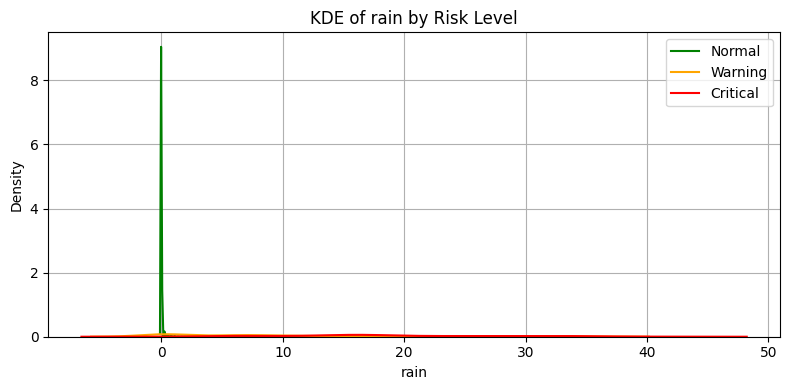

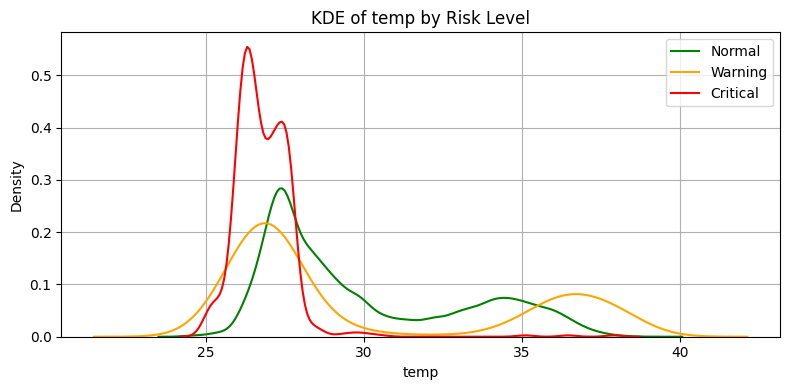

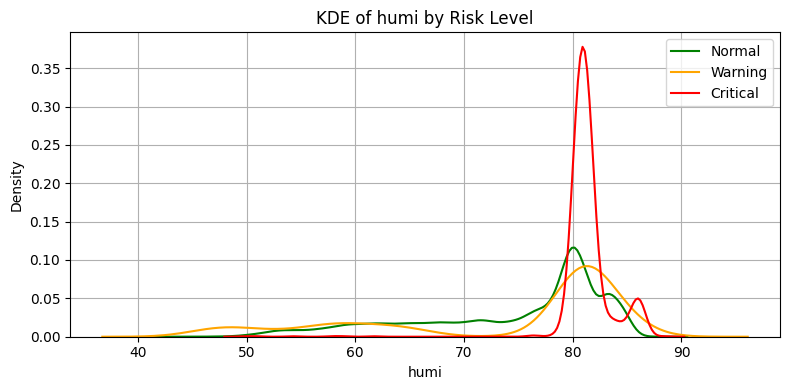

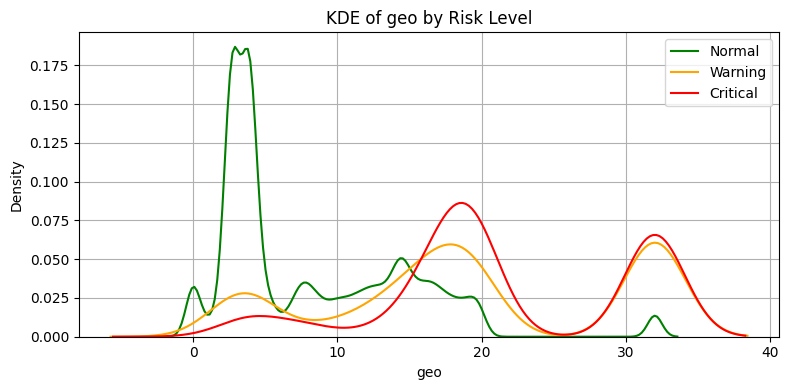

In [37]:
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Normal'][col], label='Normal', color='green')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Warning'][col], label='Warning', color='orange')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Critical'][col], label='Critical', color='red')
    plt.title(f"KDE of {col} by Risk Level")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Box Plot feature by risk

C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_3064\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set 

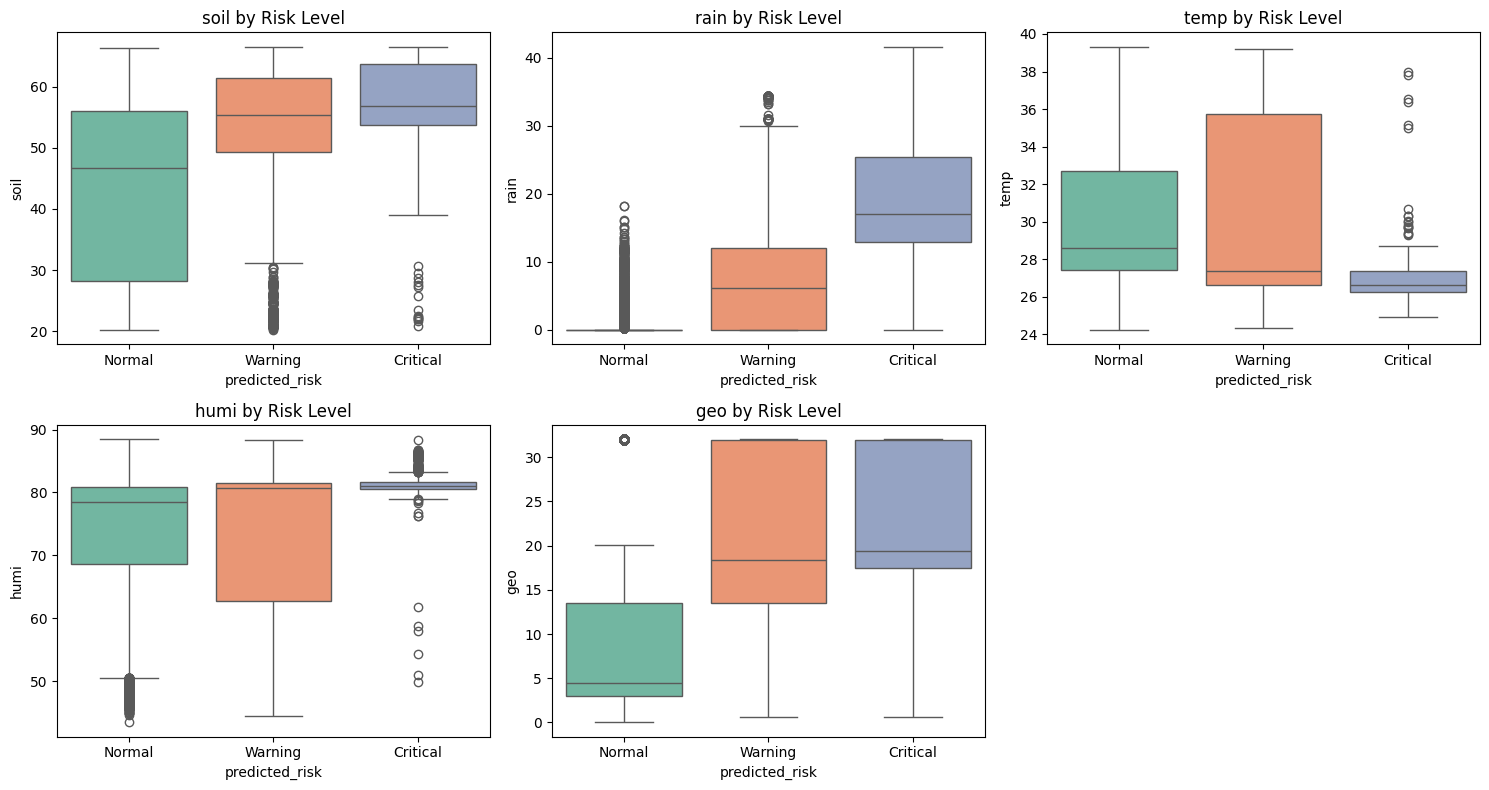

In [38]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='predicted_risk',
        y=col,
        data=df_val,
        order=['Normal', 'Warning', 'Critical'],  # 🔧 fix order here
        palette='Set2'
    )
    plt.title(f'{col} by Risk Level')
plt.tight_layout()
plt.show()


## Time Series

In [39]:
df['timestamp'].min()

Timestamp('2025-05-02 11:42:00.384119')

In [40]:
df['timestamp'].max()

Timestamp('2025-07-22 19:39:55.017000')

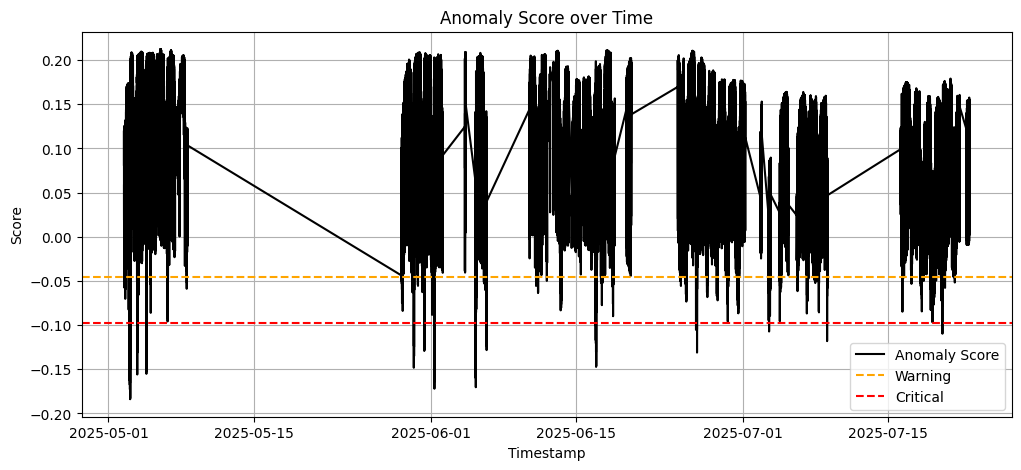

In [41]:
if 'timestamp' in df_val.columns:
    df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
    df_val_sorted = df_val.sort_values('timestamp')

    plt.figure(figsize=(12,5))
    plt.plot(df_val_sorted['timestamp'], df_val_sorted['anomaly_score'], color='black', label='Anomaly Score')
    plt.axhline(warn_thresh, color='orange', linestyle='--', label='Warning')
    plt.axhline(crit_thresh, color='red', linestyle='--', label='Critical')
    plt.title('Anomaly Score over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

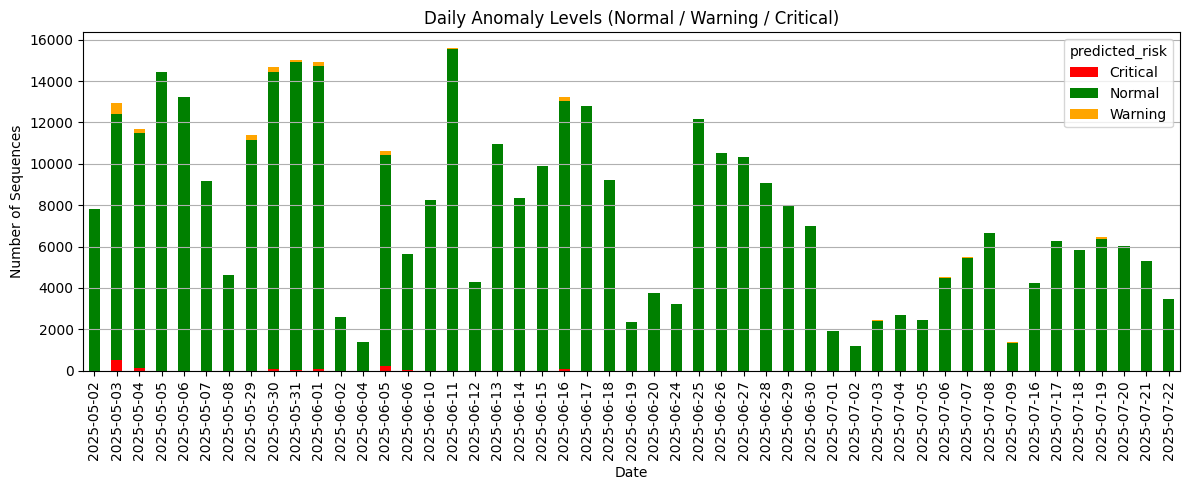

In [42]:

df_results = df_val
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

risk_order = ['Critical', 'Normal', 'Warning']

alerts_per_day = df_results.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)

for risk in risk_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0

alerts_per_day = alerts_per_day[risk_order]

colors = ['red', 'green', 'orange']

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors)

plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


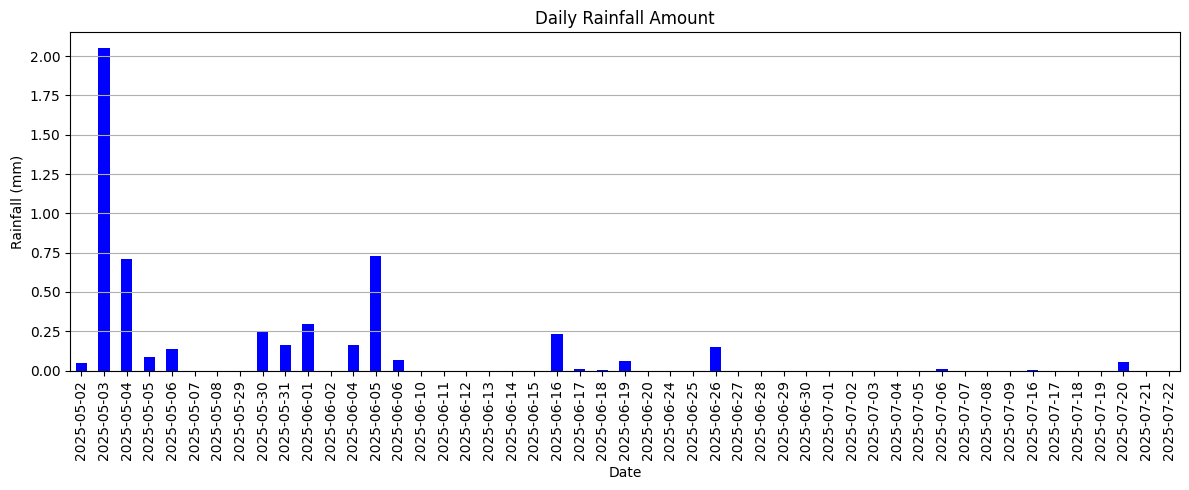

In [43]:

# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results.groupby('date')['rain'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


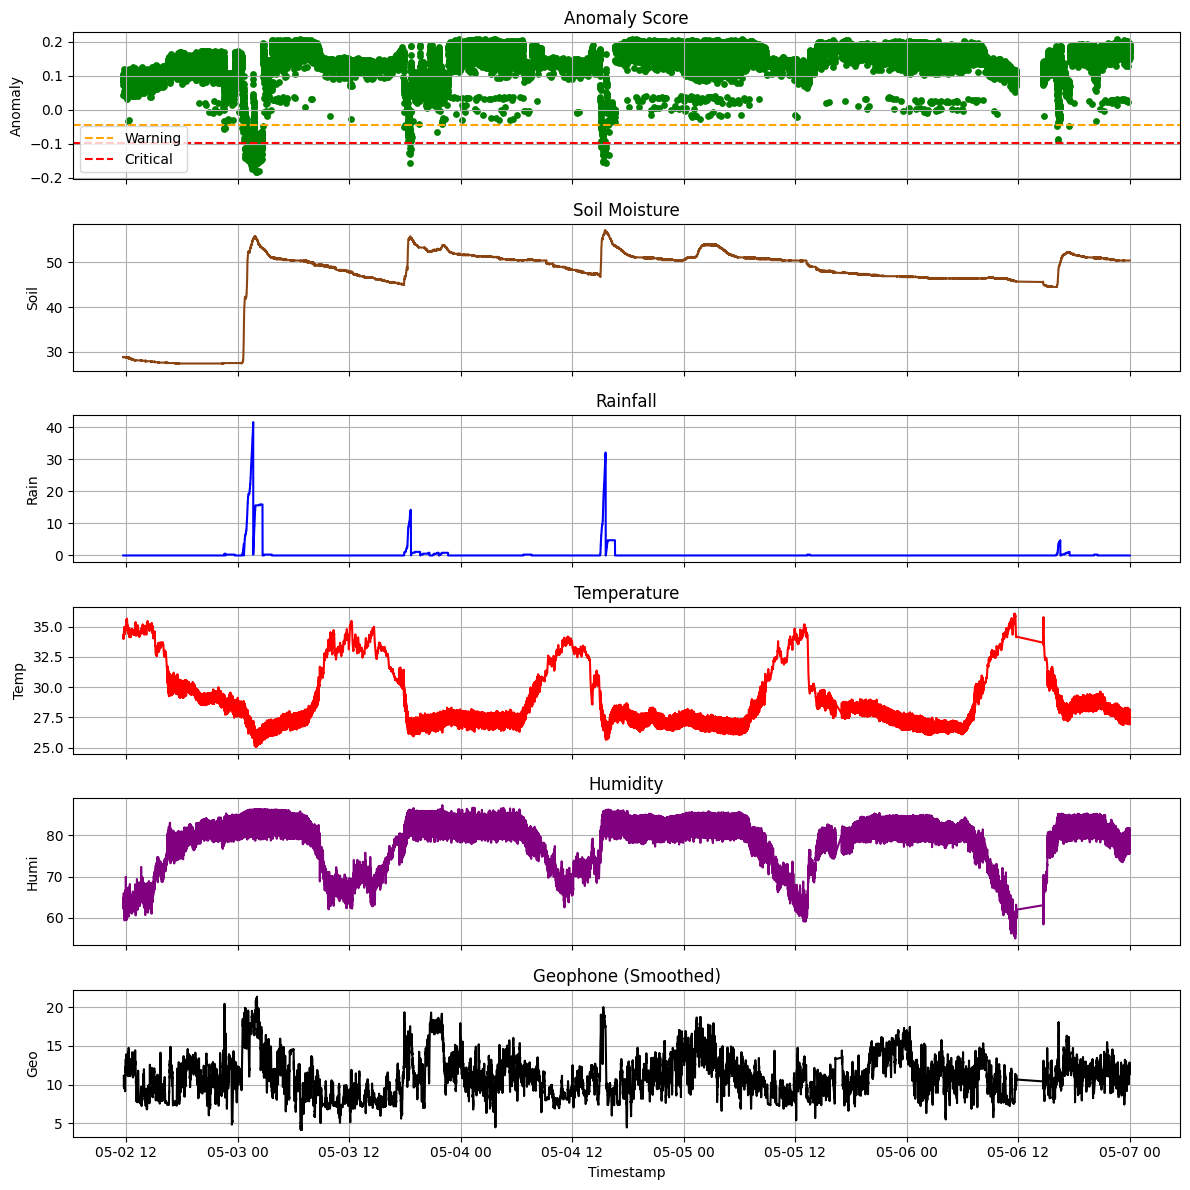

In [44]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_dev = df_val.set_index('timestamp').sort_index()
df_dev = df_dev[df_dev['devID'] == 101.0] 
df_range = df_dev.loc["2025-05-02":"2025-05-06"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone (Smoothed)")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()


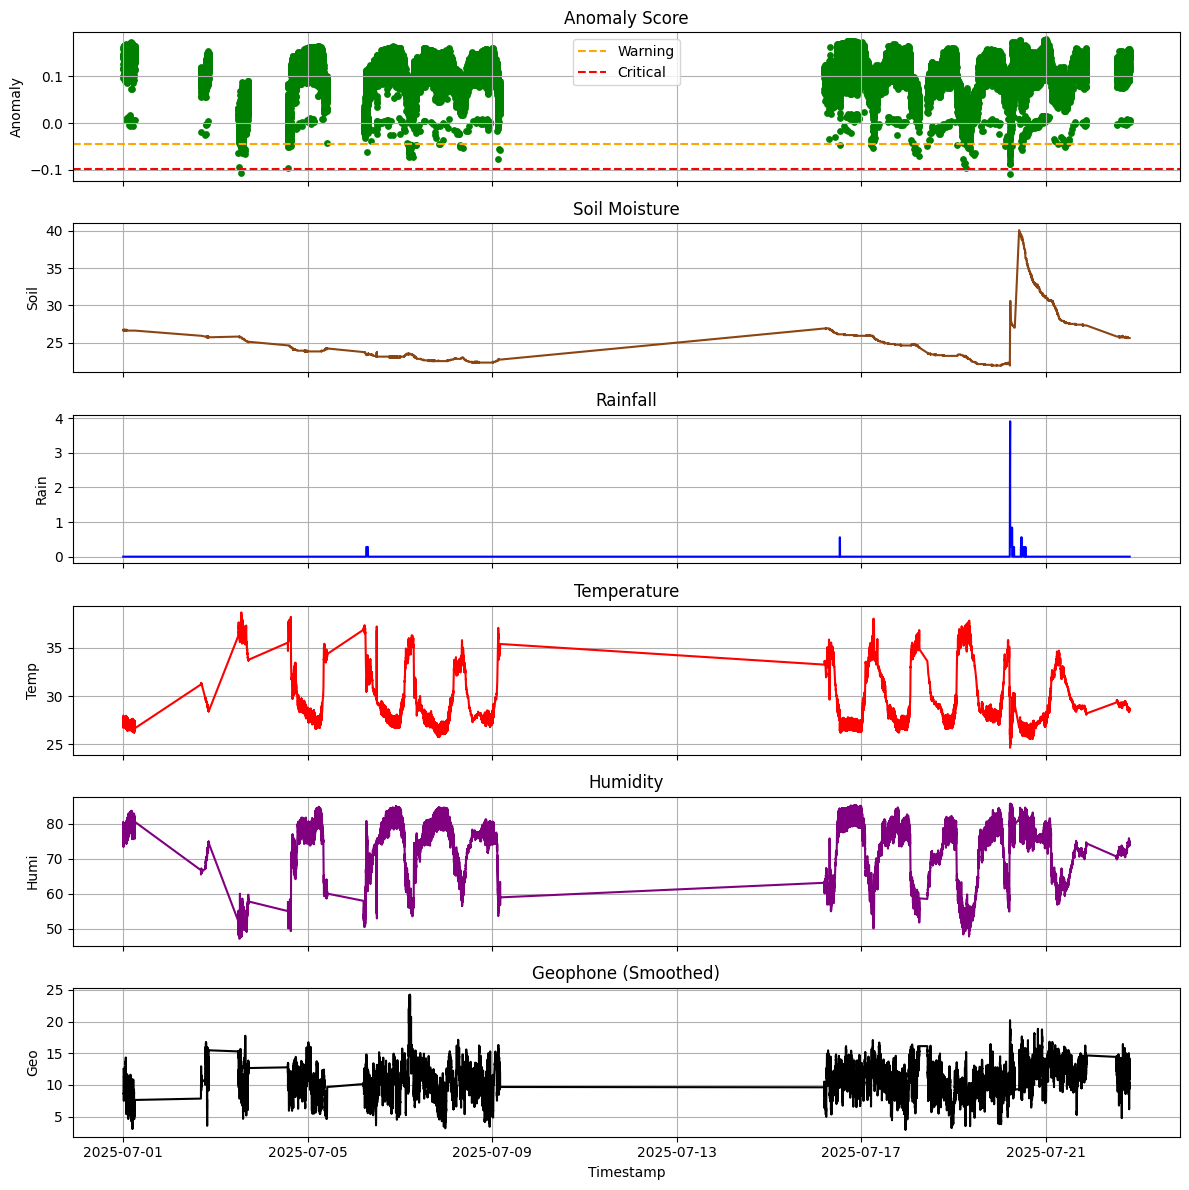

In [45]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_dev = df_val.set_index('timestamp').sort_index()
df_dev = df_dev[df_dev['devID'] == 101.0] 
df_range = df_dev.loc["2025-07-01":"2025-07-31"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone (Smoothed)")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()


# data never learn before

In [46]:
df_val2 = pd.read_csv("./../../data/dataSet2_prepared.csv")
df_val2 = df_val2.sort_values('timestamp').reset_index(drop=True)
df_val2

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng,hour,day_of_week
0,2025-07-30 03:28:43.522,101,24.400000,0.0,35.753414,54.635536,17.443285,8.638051,99.898964,3,2
1,2025-07-30 03:28:44.756,102,20.900000,0.0,36.623943,51.436863,2.512411,8.637977,99.898933,3,2
2,2025-07-30 03:28:45.992,101,24.500000,0.0,35.700008,54.654610,11.029456,8.638051,99.898964,3,2
3,2025-07-30 03:28:47.259,101,24.400000,0.0,35.673306,55.825741,8.358195,8.638053,99.898964,3,2
4,2025-07-30 03:28:48.473,102,20.900000,0.0,36.591900,53.292744,2.527225,8.637976,99.898933,3,2
...,...,...,...,...,...,...,...,...,...,...,...
34155,2025-08-03 07:43:15.179,101,26.299999,0.0,34.415577,70.317993,2.514839,8.638032,99.898972,7,6
34156,2025-08-03 07:43:24.004,102,23.400000,0.0,35.267414,69.381470,3.813702,8.637955,99.898911,7,6
34157,2025-08-03 07:43:26.139,101,26.299999,0.0,34.388874,70.276031,10.165874,8.638032,99.898972,7,6
34158,2025-08-03 07:43:35.249,102,23.400000,0.0,35.286106,65.318764,3.002546,8.637956,99.898911,7,6


In [47]:
# สร้าง features
feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
X_val2 = df_val2[feature_cols].values  # ใช้ .values แค่กับตัวที่เอาไป scale
X_val2_scaled = scaler.transform(X_val2)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_val2['anomaly_score'] = iso_model.decision_function(X_val2_scaled)


def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val2['predicted_risk'] = df_val2['anomaly_score'].apply(classify_risk)


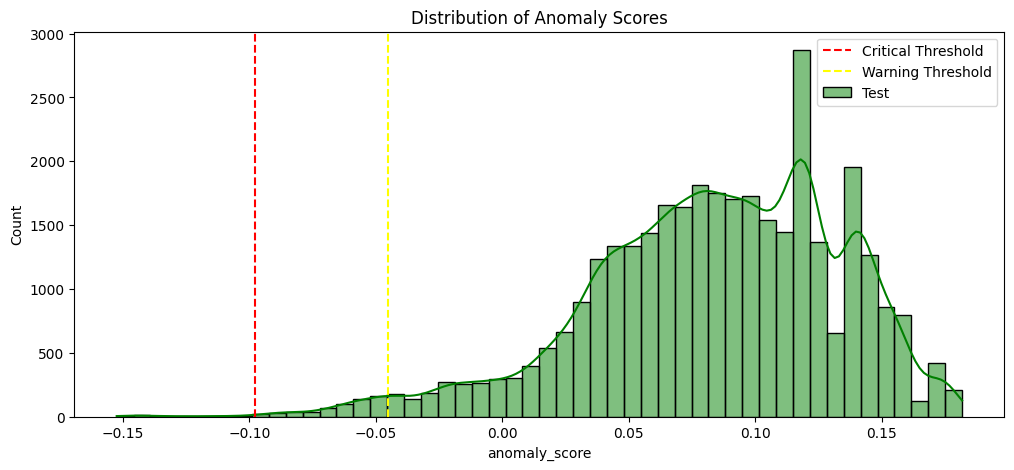

In [48]:
plt.figure(figsize=(12,5))
sns.histplot(df_val2['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()



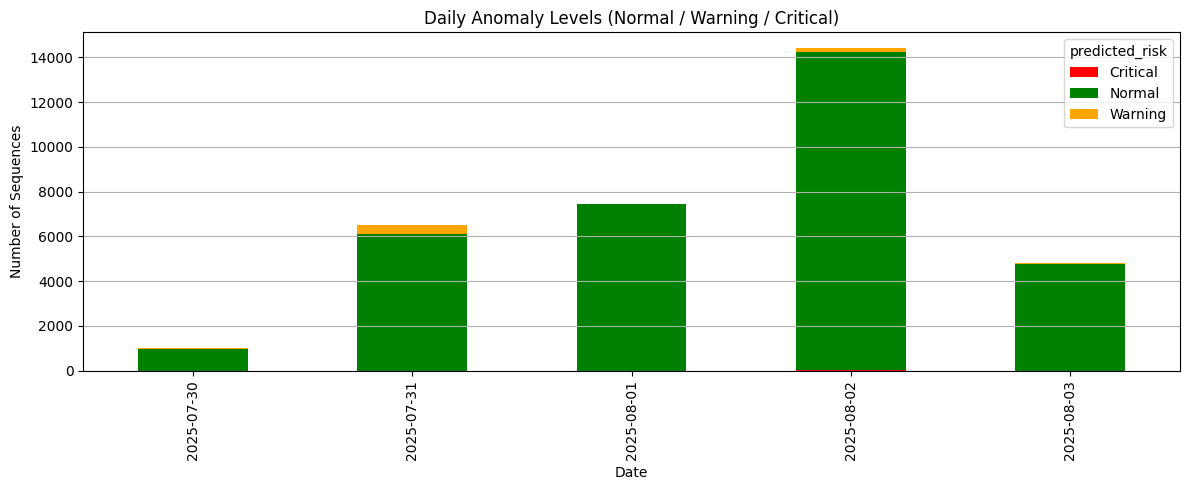

In [49]:

df_results = df_val2
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

risk_order = ['Critical', 'Normal', 'Warning']

alerts_per_day = df_results.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)

for risk in risk_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0

alerts_per_day = alerts_per_day[risk_order]

colors = ['red', 'green', 'orange']

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors)

plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


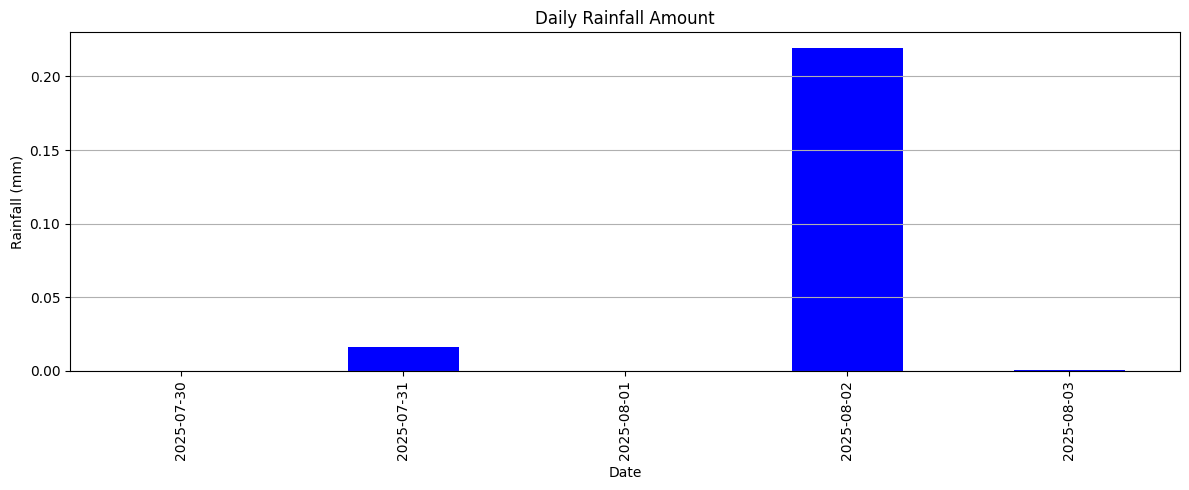

In [50]:

# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results.groupby('date')['rain'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


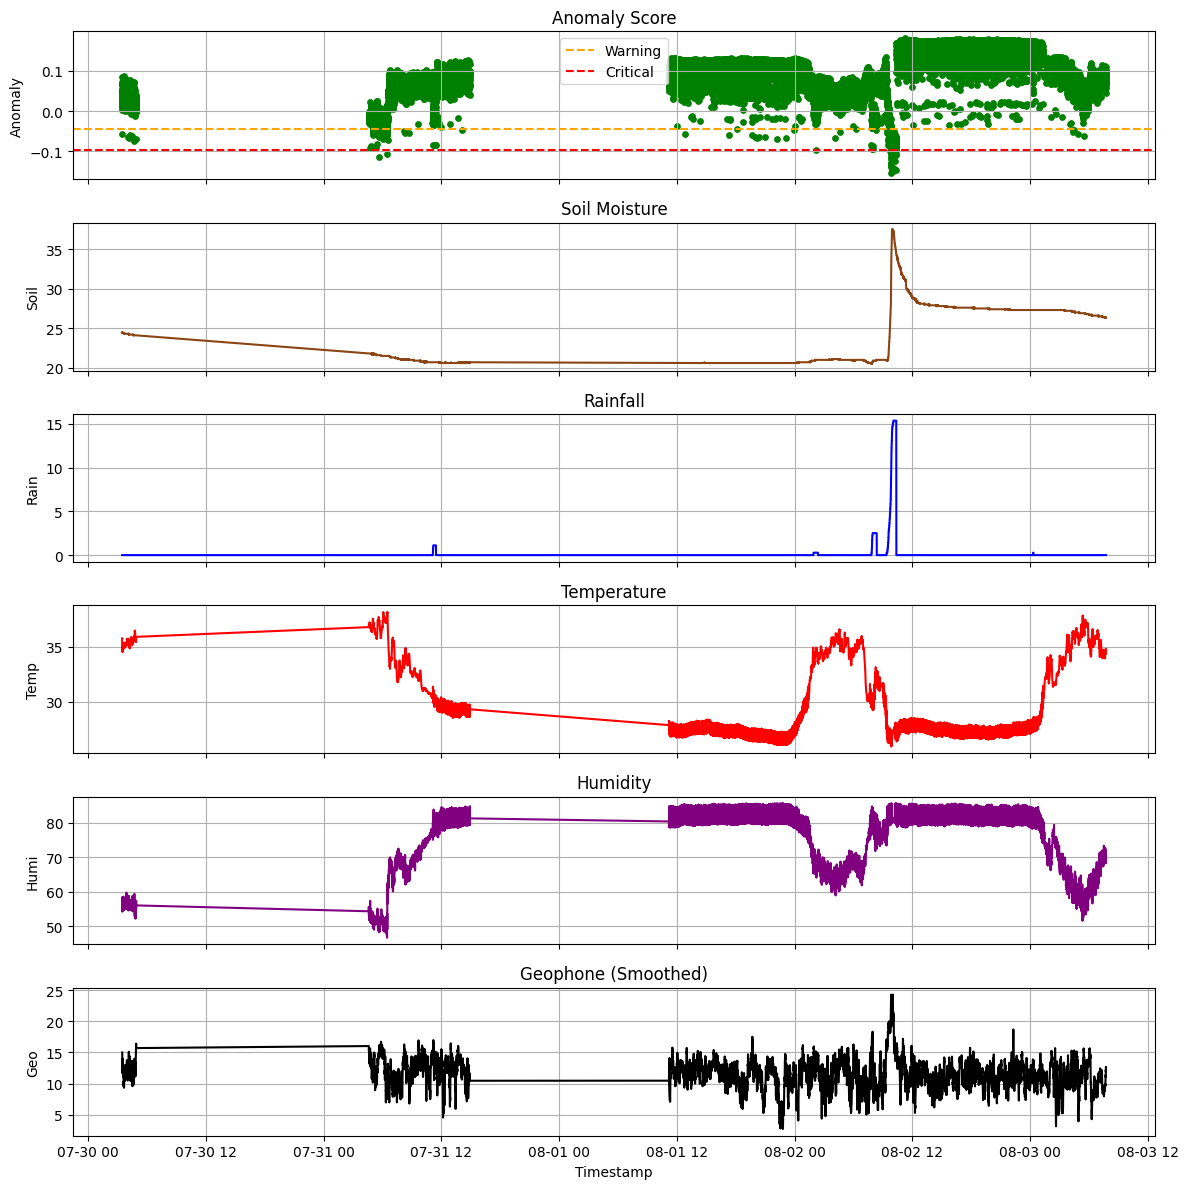

In [51]:
df_val2['timestamp'] = pd.to_datetime(df_val2['timestamp'])
df_dev = df_val2.set_index('timestamp').sort_index()
df_dev = df_dev[df_dev['devID'] == 101.0] 
df_range = df_dev.loc["2025-07-30":"2025-08-04"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone (Smoothed)")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()
